In [1]:
from FairFront import FairFront
from DataLoader_FairFront import load_data
from DiscreteFairFront import *
import numpy as np
import cvxpy as cp
import dccp

import sys
import pandas as pd
import numpy as np

import random
import pickle
import time
from tqdm import tqdm
from time import localtime, strftime

In [2]:
seed_n = 42
random.seed(seed_n)
np.random.seed(seed_n)

In [3]:
# read in data using the DataLoader module
df = load_data(name='adult', perturbed = False)   
# df = load_data(name='adult', perturbed = False, perturb = True, alpha = [0.1,0.5]) 
# pickle.save(df)

/Users/luxihe/Documents/GitHub/aleatoric_epistemic_discrimination/FairFront/DataLoader_FairFront.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTest)
/Users/luxihe/Documents/GitHub/aleatoric_epistemic_discrimination/FairFront/DataLoader_FairFront.py:48: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'race'] = df['race'].apply(lambda x: 1 if x=='White' else 0)
/Users/luxihe/Documents/GitHub/aleatoric_epistemic_discrimination/FairFront/DataLoader_FairFront.py:52: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.column

### Approximate with discrete r.v.

In [4]:
# select useful columns for computing FairFront
used_columns = df[['age_discrete', 'edu_discrete',
       'hours_discrete', 'marital-status_Married-civ-spouse' , 'relationship_Husband','relationship_Wife', 'gender','SY',]]



In [5]:
pmf_dict = {0:{}, 1:{}, 2:{}, 3:{}}

def get_type_count(row):
    sy = row['SY']
    key = (row['age_discrete'],row['edu_discrete'],row['hours_discrete'],row['marital-status_Married-civ-spouse'], row['relationship_Husband'], row['relationship_Wife'], row['gender'])
    if key not in pmf_dict[sy]:
        pmf_dict[sy].update({key: 1})
    else:
        pmf_dict[sy][key] =  pmf_dict[sy][key] + 1
    

for index, row in used_columns.iterrows():
    get_type_count(row)

for i in range(4):
    total_i = sum(pmf_dict[i].values())
    pmf_dict[i] = {key: value / total_i for key, value in pmf_dict[i].items()}


In [6]:
# output support as a list 
support_list = []
for i in range(4):
    support_list += list(pmf_dict[i].keys())

support_X = list(set(support_list)) # support of input features
calX = len(support_X)# support size of input features
calX


4849

In [7]:
def get_pmf(dictionary, x):
    '''
    if x is in dictionary pmf_dict[i], then use that value. If not, fill in 0
    '''
    if x in dictionary:
        return dictionary[x]
    else:
        return 0 

# transition matrix from (s,y) to x
T_SY_X  = np.vstack([[get_pmf(pmf_dict[0], x) for x in support_X], \
           [get_pmf(pmf_dict[1], x) for x in support_X], \
           [get_pmf(pmf_dict[2], x) for x in support_X], \
           [get_pmf(pmf_dict[3], x) for x in support_X]
            ])

T_SY_X.shape

# can then use it to generate approximate for True FairFront

(4, 4849)

#### Obtain transition matrix and conditional distribution

In [8]:
A = 2
C = 2
sensitive_s = 'gender'
label_y = 'income'
# get the mu_s,y values, encoded in matrix mu_SY
mu_SY = np.zeros((A, C))
mu_SY = np.zeros((2, 2))
for index, row in df.iterrows():
    s,y = int(row[sensitive_s]), int(row[label_y])
    mu_SY[s][y] = mu_SY[s][y] + 1
mu_SY = mu_SY/len(df)

map_ind_X = dict(zip(range(calX), support_X))
map_X_ind = dict(zip(support_X, range(calX)))

In [9]:
def g_emp(x):
    '''
    compute g function from the empirical distribution
    '''
    result_vector = []
    ind_x = map_X_ind[x]
    for s in range(A):
        for y in range(C):
            result_vector.append(T_SY_X[s*C + y, ind_x] * mu_SY[s][y])
    #normalize
    result_vector = result_vector/(sum(result_vector))
    return result_vector

In [10]:
distinf = {"T": T_SY_X, "map": map_ind_X, "mu_SY": mu_SY}

#### Generate FairFront

In [11]:
# fairness threshold
alpha_SP = 1.0
alpha_OAE = 1.0

In [12]:
# the sharp curve part

epsilon = []
opt_list = [] # List of FairFront values
opt_discrete_list = []

for i in np.linspace(0,0.06,10):
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    FairFront_value = FairFront(A, C, g_emp,sensitive_s = sensitive_s, label_y=label_y,InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 20)

    optimal_value,_,_ = FairFront_value.Algorithm()
    opt_list.append(optimal_value)
    
    
    # FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    # value = FairFront_discrete.FairFront()

    # opt_discrete_list.append(value)
    
    
    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("opt_list:", opt_list)

current i: 0.0
Time for this iteration: 6.317 mins

opt_list: [0.8278810645378111]
current i: 0.006666666666666666
Time for this iteration: 6.383 mins

opt_list: [0.8278810645378111, 0.8300821406247829]
current i: 0.013333333333333332
Time for this iteration: 6.467 mins

opt_list: [0.8278810645378111, 0.8300821406247829, 0.8322832171840927]
current i: 0.019999999999999997
Time for this iteration: 6.667 mins

opt_list: [0.8278810645378111, 0.8300821406247829, 0.8322832171840927, 0.8344842909267509]
current i: 0.026666666666666665
Time for this iteration: 7.017 mins

opt_list: [0.8278810645378111, 0.8300821406247829, 0.8322832171840927, 0.8344842909267509, 0.8366853650200555]
current i: 0.03333333333333333
Time for this iteration: 7.267 mins

opt_list: [0.8278810645378111, 0.8300821406247829, 0.8322832171840927, 0.8344842909267509, 0.8366853650200555, 0.8388864400667974]
current i: 0.039999999999999994
Time for this iteration: 7.283 mins

opt_list: [0.8278810645378111, 0.8300821406247829

/Users/luxihe/miniforge3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Time for this iteration: 7.233 mins

opt_list: [0.8278810645378111, 0.8300821406247829, 0.8322832171840927, 0.8344842909267509, 0.8366853650200555, 0.8388864400667974, 0.8410875164428934, 0.8432834014964895, 0.8448077852367369]
current i: 0.06
Time for this iteration: 6.983 mins

opt_list: [0.8278810645378111, 0.8300821406247829, 0.8322832171840927, 0.8344842909267509, 0.8366853650200555, 0.8388864400667974, 0.8410875164428934, 0.8432834014964895, 0.8448077852367369, 0.8457348062202513]


In [13]:
# the flat curve part
for i in np.linspace(0.07, 0.15, 5):
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    FairFront_value = FairFront(A, C, g_emp,sensitive_s = sensitive_s, label_y=label_y,InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 20)

    optimal_value,_,_ = FairFront_value.Algorithm()
    opt_list.append(optimal_value)

    # FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    # value = FairFront_discrete.FairFront()

    # opt_discrete_list.append(value)
    
    
    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("opt_list:", opt_list)

        

current i: 0.07
Time for this iteration: 7.233 mins

opt_list: [0.8278810645378111, 0.8300821406247829, 0.8322832171840927, 0.8344842909267509, 0.8366853650200555, 0.8388864400667974, 0.8410875164428934, 0.8432834014964895, 0.8448077852367369, 0.8457348062202513, 0.8463685033589747]
current i: 0.09
Time for this iteration: 7.000 mins

opt_list: [0.8278810645378111, 0.8300821406247829, 0.8322832171840927, 0.8344842909267509, 0.8366853650200555, 0.8388864400667974, 0.8410875164428934, 0.8432834014964895, 0.8448077852367369, 0.8457348062202513, 0.8463685033589747, 0.8464486409948608]
current i: 0.11
Time for this iteration: 7.900 mins

opt_list: [0.8278810645378111, 0.8300821406247829, 0.8322832171840927, 0.8344842909267509, 0.8366853650200555, 0.8388864400667974, 0.8410875164428934, 0.8432834014964895, 0.8448077852367369, 0.8457348062202513, 0.8463685033589747, 0.8464486409948608, 0.8464486405169865]
current i: 0.13
Time for this iteration: 8.517 mins

opt_list: [0.8278810645378111, 0.83

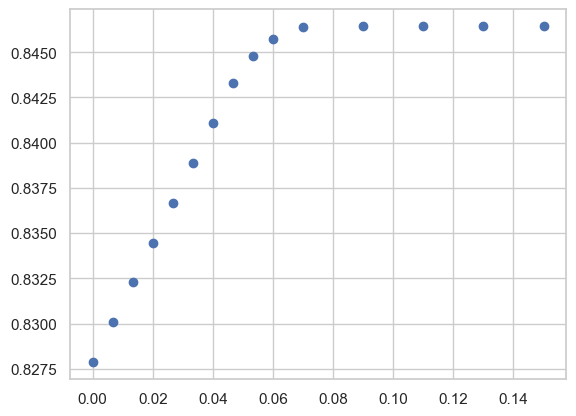

In [14]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
sns.set(style="whitegrid")

plt.plot(epsilon, opt_list, 'o')